# KerasCV로 객체 감지

**저자:** [lukewood](https://twitter.com/luke_wood_ml), Ian Stenbit, Tirth Patel  
**생성일:** 2023/04/08  
**최종편집일:** 2023/08/10  
**설명:** KerasCV를 사용하여 객체 감지 모델을 트레이닝합니다.

KerasCV는 객체 감지 문제를 해결하기 위한 완전한 프로덕션 등급 API 세트를 제공합니다.
이러한 API에는 객체 감지 특화 데이터 보강 기술, Keras 네이티브 COCO 메트릭,
바운딩 박스 형식 변환 유틸리티, 시각화 도구, 사전 트레이닝된 객체 감지 모델,
그리고 최첨단 객체 감지 모델을 스스로 트레이닝하는 데 필요한 모든 것이 포함됩니다!

KerasCV의 객체 감지 API를 한 번 사용해 보겠습니다.

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## 객체 감지 소개

객체 감지는 주어진 이미지 내에서 객체를 식별, 분류 및 지역화하는 프로세스입니다.
일반적으로, 입력은 이미지이고, 레이블은 선택적 클래스 레이블이 있는 경계 상자입니다.
객체 감지는 분류의 확장으로 생각할 수 있지만,
이미지에 대한 하나의 클래스 레이블 대신,
임의의 수의 클래스를 감지하고 지역화해야 합니다.

**예:**

<img width="300" src="https://i.imgur.com/8xSEbQD.png">

위 이미지의 데이터는 다음과 같습니다.

```python
image = [height, width, 3]
bounding_boxes = {
  "classes": [0], # 0은 "cat"을 나타내는 임의의 클래스 ID입니다.
  "boxes": [[0.25, 0.4, .15, .1]]
   # 경계 상자는 "rel_xywh" 형식이므로,
   # 0.25는 이미지 전체 길이의 25% 지점에서 경계 상자의 시작을 나타냅니다.
   # .15는 너비가 이미지 너비의 15%임을 나타냅니다.
}
```

[_You Only Look Once_](https://arxiv.org/abs/1506.02640)(일명 YOLO)가 시작된 이래로,
객체 감지는 주로 딥러닝을 사용하여 해결되었습니다.
대부분의 딥러닝 아키텍처는 객체 감지 문제를,
여러 작은 분류 문제와 여러 회귀 문제의 조합으로 교묘하게 구성하여 이를 수행합니다.

더 구체적으로, 이는 입력 이미지에서 다양한 모양과 크기의 앵커 상자를 여러 개 생성하고,
각각에 클래스 레이블과 `x`, `y`, `width` 및 `height` 오프셋을 할당하여 수행됩니다.
모델은 각 상자의 클래스 레이블과,
객체로 예측되는 각 상자의 `x`, `y`, `width` 및 `height` 오프셋을 예측하도록 트레이닝됩니다.

**일부 샘플 앵커 상자(anchor boxes)의 시각화**:

<img width="400" src="https://i.imgur.com/cJIuiK9.jpg">

객체 감지는 기술적으로 복잡한 문제이지만,
다행히도 우리는 훌륭한 결과를 얻기 위한 확실한 방법을 제공합니다.
시작해 봅시다!

## 사전 트레이닝된 모델로 감지 수행

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

KerasCV 객체 감지 API에서 가장 높은 레벨의 API는 `keras_cv.models` API입니다.
이 API에는 [`keras_cv.models.YOLOV8Detector`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/models/tasks/yolo_v8_detector#yolov8detector-class)와 같은 완전히 사전 트레이닝된 객체 감지 모델이 포함됩니다.

`pascalvoc` 데이터 세트에 대해 사전 트레이닝된 YOLOV8Detector를 구성하여 시작해 보겠습니다.

In [3]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 701kB/s]
100%|██████████| 99.5M/99.5M [00:06<00:00, 15.6MB/s]


`bounding_box_format` 인수를 주목하세요?

위 섹션에서, 경계 상자의 형식을 떠올려 보세요.

```python
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

이 인수는 파이프라인에서 레이블 딕셔너리의 `"boxes"` 필드에 있는 값이 취하는 형식을 _정확히_ 설명합니다.
예를 들어, 왼쪽 위 모서리가 좌표(100, 100)에 있고 너비가 55, 높이가 70인,
`xywh` 형식의 상자는 다음과 같이 표현됩니다.

```python
[100, 100, 55, 75]
```

또는 동등하게 `xyxy` 형식으로:

```python
[100, 100, 155, 175]
```

간단해 보일 수 있지만, KerasCV 객체 감지 API의 중요한 부분입니다!
경계 상자를 처리하는 모든 구성 요소에는 `bounding_box_format` 인수가 필요합니다.
KerasCV 경계 상자 형식에 대한 자세한 내용은,
[API 문서](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/bounding_box/formats/)에서 확인할 수 있습니다.

경계 상자에 대한 올바른 형식이 없기 때문에 이렇게 합니다!
다른 파이프라인의 구성 요소는 다른 형식을 기대하므로,
형식을 지정하도록 요구함으로써,
구성 요소가 읽기 쉽고 재사용 가능하며 명확하게 유지되도록 합니다.
상자 형식 변환 버그는 아마도 객체 감지 파이프라인에서 가장 흔한 버그 표면일 것입니다.
이 매개변수를 요구함으로써 이러한 버그를 완화합니다.
(특히 여러 소스의 코드를 결합할 때)

다음으로 이미지를 로드해 보겠습니다.

1215963/1215963 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


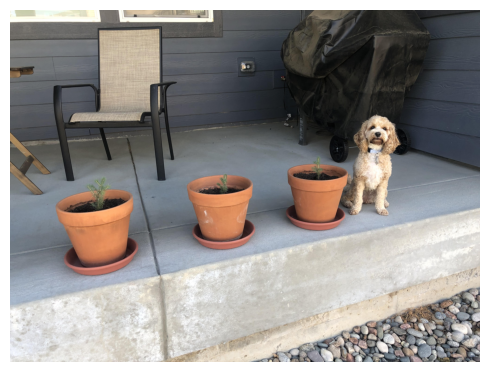

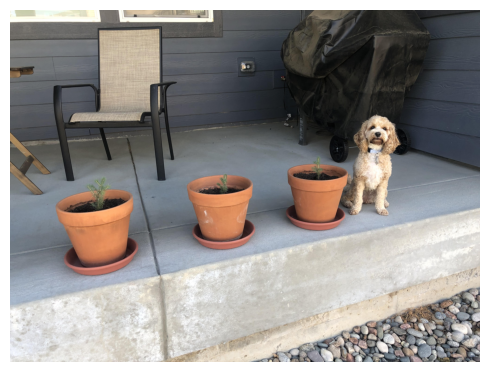

In [5]:
# filepath = keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
filepath = keras.utils.get_file(origin="https://github.com/tenkeyless/keras-io_test/blob/main/assets/gCNcJJI.jpeg?raw=true")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

ResNet50 백본과 함께 `YOLOV8Detector` 아키텍처를 사용하려면,
이미지 크기를 64로 나누어 떨어지는 크기로 조정해야 합니다.
이는 ResNet의 컨볼루션 레이어에서 수행되는,
다운스케일링 연산 수와의 호환성을 보장하기 위한 것입니다.

크기 조정 연산으로 인해 입력의 종횡비가 왜곡되면, 모델의 성능이 상당히 떨어집니다.
사용 중인 사전 트레이닝된 `"yolo_v8_m_pascalvoc"` 사전 설정의 경우,
naive 크기 조정 연산을 사용할 때,
`pascalvoc/2012` 평가 세트에 대한 최종 `MeanAveragePrecision`이 `0.38`에서 `0.15`로 떨어집니다.

또한, 분류에서처럼 종횡비를 유지하기 위해 자르면, 모델에서 일부 경계 상자가 완전히 누락될 수 있습니다.
따라서, 객체 감지 모델에서 추론을 실행할 때는, 원하는 크기로 패딩을 사용하는 동시에,
가장 긴 크기를 종횡비에 맞게 크기를 조정하는 것이 좋습니다.

KerasCV는 크기 조절을 제대로 쉽게 만듭니다.
간단히 `pad_to_aspect_ratio=True`를 [`keras_cv.layers.Resizing`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/preprocessing/resizing#resizing-class) 레이어에 전달하면 됩니다.

이는 한 줄의 코드로 구현할 수 있습니다.

In [6]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

이는 추론 전처리 파이프라인으로 사용할 수 있습니다.

In [7]:
image_batch = inference_resizing([image])

`keras_cv.visualization.plot_bounding_box_gallery()`는,
각 상자가 어떤 클래스에 할당되었는지 강조하기 위한 `class_mapping` 매개변수를 지원합니다.
이제 클래스 매핑을 조립해 보겠습니다.

In [8]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

다른 [`keras.Model`](https://codecompose7.github.io/keras-doc-kr.github.io/api/models/model#model-class)과 마찬가지로,
`model.predict()` API를 사용하여 경계 상자를 예측할 수 있습니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


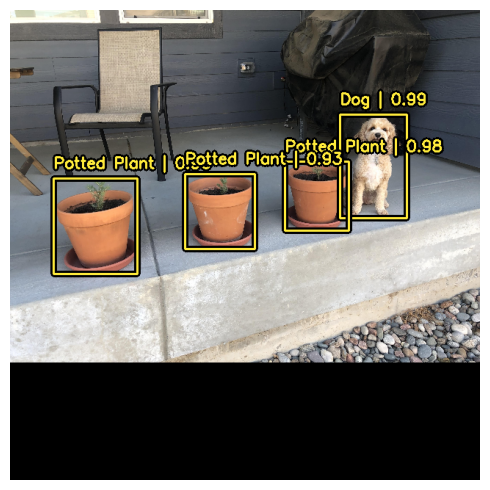

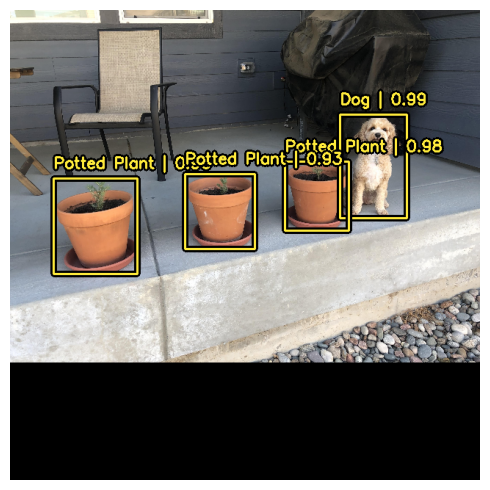

In [9]:
y_pred = pretrained_model.predict(image_batch)
# y_pred는 바운딩 박스 텐서입니다.
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

이 간편하고 직관적인 추론 워크플로를 지원하기 위해,
KerasCV는 `YOLOV8Detector` 클래스 내부에서 비최대 억제(Non-max suppression)를 수행합니다.
Non-max 억제는 모델이 동일한 객체에 대해,
여러 상자를 감지하는 문제를 해결하는 기존 컴퓨팅 알고리즘입니다.

Non-max 억제는 구성 가능성이 매우 높은 알고리즘이며,
대부분의 경우 모델의 Non-max 억제 연산 설정을 커스터마이즈하고 싶을 것입니다.
이는 `prediction_decoder` 인수를 재정의하여 수행할 수 있습니다.

이 개념을 보여주기 위해, YOLOV8Detector에서 Non-max 억제를 일시적으로 비활성화해 보겠습니다.
이는 `prediction_decoder` 속성에 작성하여 수행할 수 있습니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


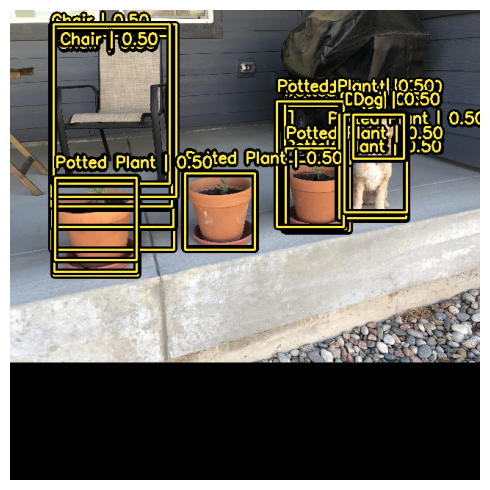

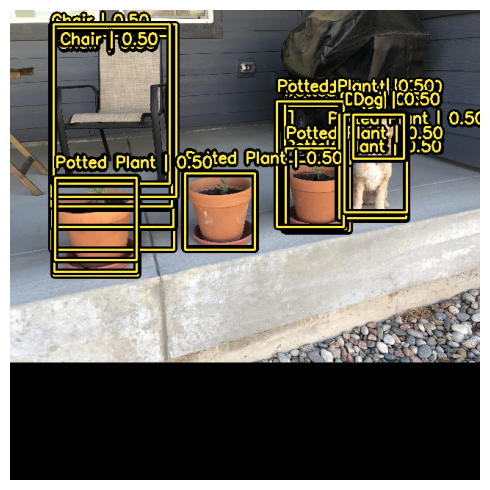

In [10]:
# 다음 NonMaxSuppression 레이어는 연산을 비활성화하는 것과 동일합니다.
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

다음으로, 우리의 사용 사례에 맞게 `keras_cv.layers.NonMaxSuppression`을 재구성해 보겠습니다!
이 경우 `iou_threshold`를 `0.2`로, `confidence_threshold`를 `0.7`로 조정합니다.

`confidence_threshold`를 높이면, 모델이 신뢰 점수가 더 높은 상자만 출력합니다.
`iou_threshold`는 두 상자가 하나를 잘라내기 위해 가져야 하는 교집합(IoU)에 대한 임계값을 제어합니다.
[이러한 매개변수에 대한 자세한 내용은 TensorFlow API 문서](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)에서 확인할 수 있습니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


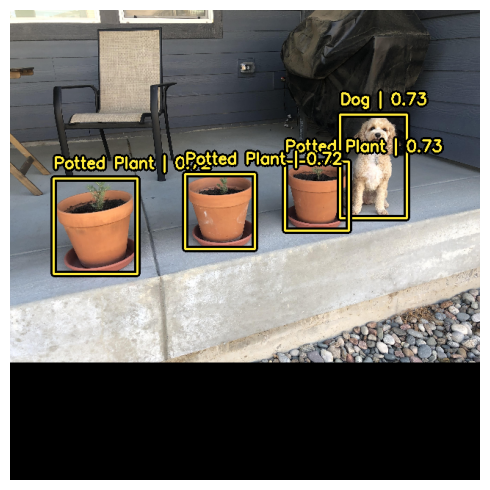

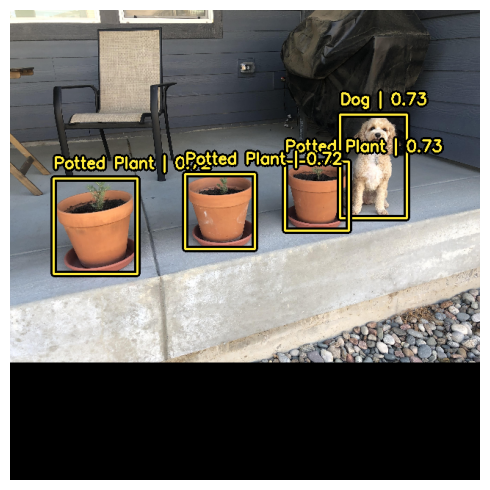

In [11]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # 예측이 가지치기(pruned out)되도록 필요한 임계값을 낮추세요
    iou_threshold=0.2,
    # NMS를 통과하기 위한 예측 신뢰도 임계값 조정
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

훨씬 좋아 보이네요!

## 커스텀 객체 감지 모델 트레이닝

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

객체 감지 아마추어이든 노련한 베테랑이든, 객체 감지 파이프라인을 처음부터 조립하는 것은 엄청난 작업입니다.
다행히도, 모든 KerasCV 객체 감지 API는 모듈식 구성 요소로 빌드됩니다.
완전한 파이프라인이 필요하든, 객체 감지 모델만 필요하든,
심지어 상자를 `xywh` 형식에서 `xyxy` 형식으로 변환하는 변환 유틸리티만 필요하든, KerasCV가 해결해 드립니다.

이 가이드에서는 KerasCV 객체 감지 모델을 위한 전체 트레이닝 파이프라인을 조립합니다.
여기에는 데이터 로딩, 보강, 메트릭 평가 및 추론이 포함됩니다!

시작하려면, 모든 import를 정리하고, 글로벌 구성 매개변수를 정의해 보겠습니다.

In [12]:
BATCH_SIZE = 4

## 데이터 로딩

시작하기 위해, 데이터 로딩과 바운딩 박스 포맷팅에 대해 논의해 보겠습니다.
KerasCV에는 바운딩 박스에 대한 사전 정의된 포맷이 있습니다.
이를 준수하려면, 바운딩 박스를 아래 사양과 일치하는 딕셔너리에 패키징해야 합니다.

```python
bounding_boxes = {
    # num_boxes는 Ragged 차원일 수 있습니다.
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

`bounding_boxes['boxes']`에는 KerasCV에서 지원하는 `bounding_box_format`에서 바운딩 박스의 좌표가 포함됩니다.
KerasCV는 바운딩 박스를 처리하는 모든 구성 요소에서 `bounding_box_format` 인수가 필요합니다.
이는 개별 구성 요소를 객체 감지 파이프라인에 플러그 앤 플레이하는 기능을 극대화하고,
객체 감지 파이프라인에서 코드를 자체 문서화하기 위해 수행됩니다.

KerasCV API 스타일과 일치하도록, 커스텀 데이터 로더를 작성할 때,
`bounding_box_format` 인수도 지원하는 것이 좋습니다.
이렇게 하면, 데이터 로더를 호출하는 사람에게 바운딩 박스의 형식이 무엇인지 명확하게 알 수 있습니다.
이 예에서는, 상자를 `xywh` 형식으로 포맷합니다.

예를 들어:

```python
train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)
```

이렇게 하면 `xywh` 형식의 경계 상자가 명확하게 생성됩니다.
KerasCV 경계 상자 형식에 대한 자세한 내용은,
[API 문서]({{ site.baseurl }}/api/keras_cv/bounding_box/formats/)에서 확인할 수 있습니다.

데이터는 `{"images": images, "bounding_boxes": bounding_boxes}` 형식으로 로드됩니다.
이 형식은 모든 KerasCV 전처리 구성 요소에서 지원됩니다.

데이터를 로드하고 데이터가 예상대로 표시되는지 확인해 보겠습니다.

In [13]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/4952 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteLI3MGH/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteLI3MGH/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteLI3MGH/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


다음으로, 데이터를 배치처리해 보겠습니다.

KerasCV 객체 감지 작업에서는 사용자가 입력의 불규칙 배치(ragged batches)를 사용하는 것이 좋습니다.
이는 PascalVOC에서 이미지 크기가 다를 수 있고,
이미지당 경계 상자의 수가 다를 수 있기 때문입니다.

[`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 파이프라인에서,
불규칙 데이터 세트를 구성하려면, `ragged_batch()` 메서드를 사용할 수 있습니다.

In [14]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

데이터 세트가 KerasCV에서 기대하는 형식을 따르고 있는지 확인해 보겠습니다.
`visualize_dataset()` 함수를 사용하면,
데이터가 KerasCV에서 기대하는 형식인지 시각적으로 확인할 수 있습니다.
경계 상자가 보이지 않거나 잘못된 위치에 보이는 경우,
데이터 형식이 잘못되었다는 신호입니다.

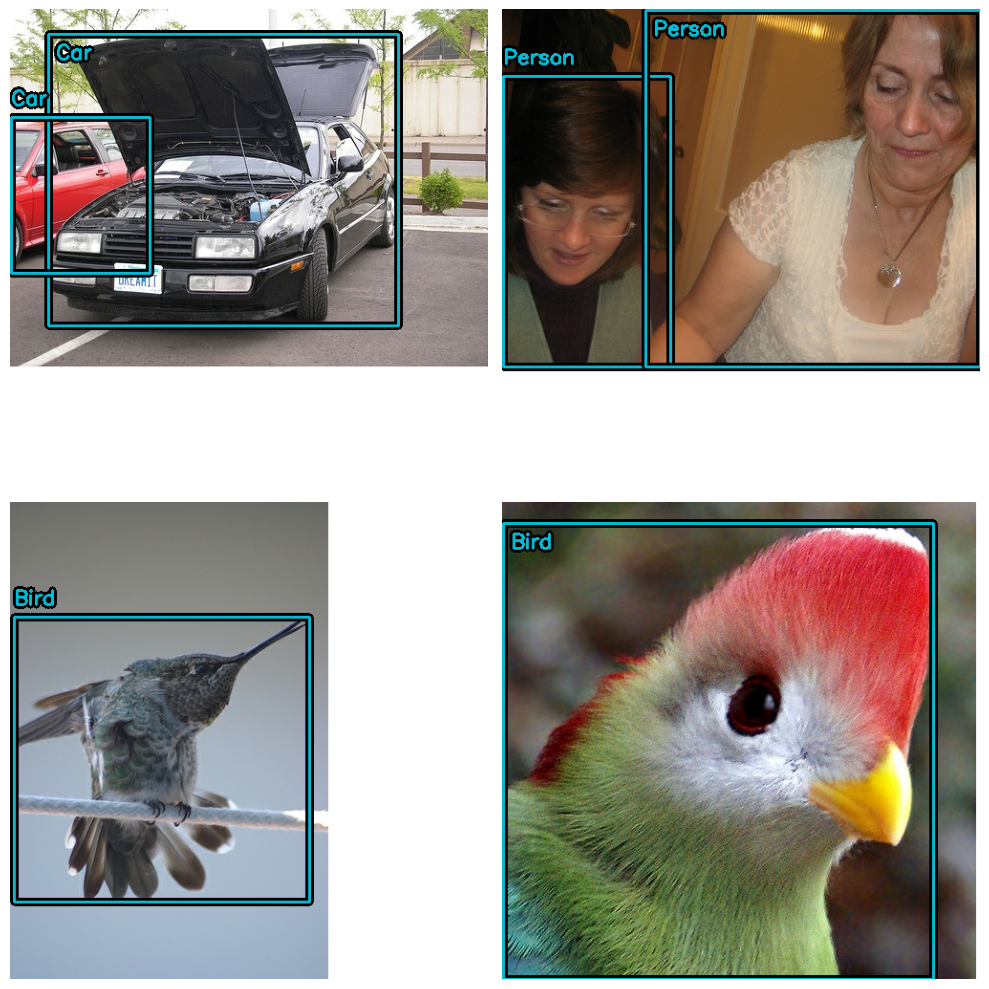

In [15]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

평가 세트의 경우:

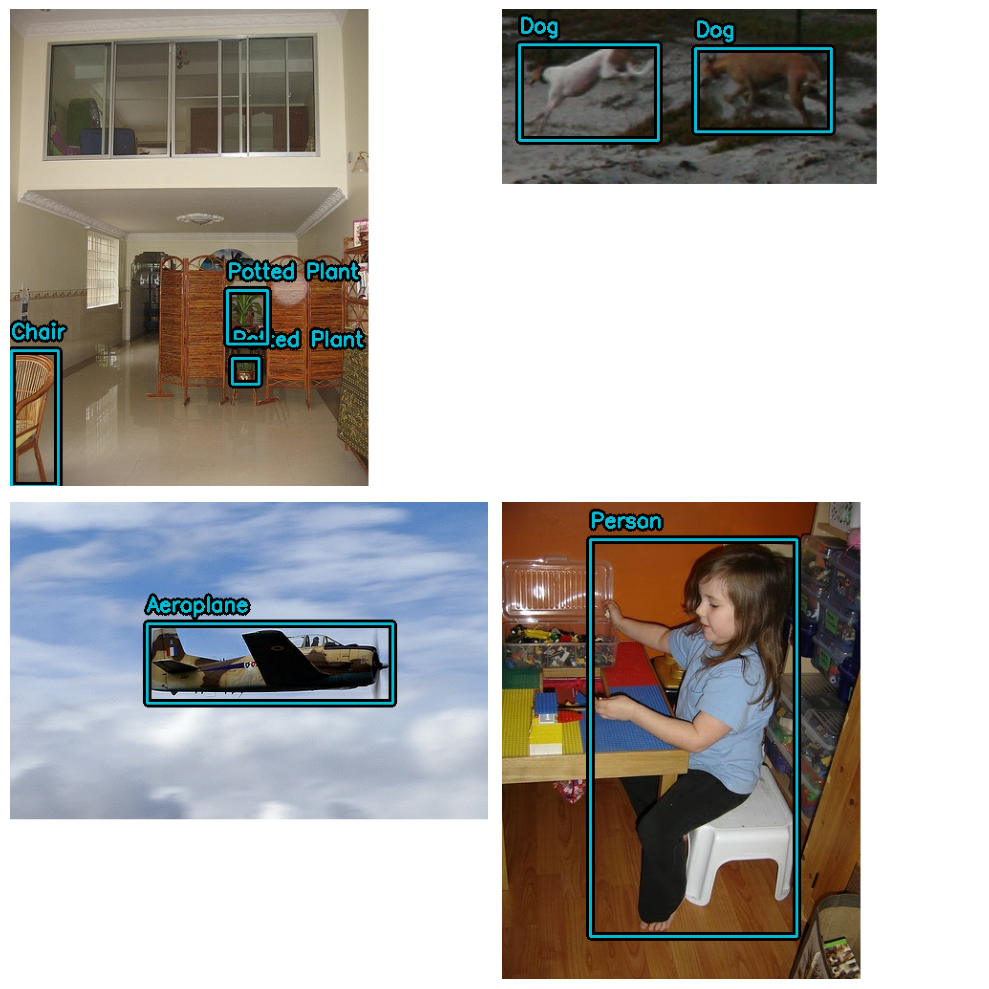

In [16]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # 로컬 머신에서 실험을 실행하지 않는 경우,
    # `path`를 사용하여 `visualize_dataset()`가 플롯을 파일에 덤프하도록 할 수도 있습니다.
    # path="eval.png"
)

모든 것이 예상대로 구조화된 것 같습니다.
이제 데이터 보강 파이프라인을 구축할 수 있습니다.

## 데이터 보강

객체 감지 파이프라인을 구축할 때 가장 어려운 작업 중 하나는 데이터 보강입니다.
이미지 보강 기술은 기본 바운딩 박스를 인식하고, 이에 따라 업데이트해야 합니다.

다행히도, KerasCV는 광범위한 [데이터 보강 레이어](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/layers/preprocessing/) 라이브러리를 통해,
바운딩 박스 보강을 기본적으로 지원합니다.
아래 코드는 Pascal VOC 데이터 세트를 로드하고,
[`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) 파이프라인 내에서,
즉석에서 바운딩 박스 친화적인 데이터 보강을 수행합니다.

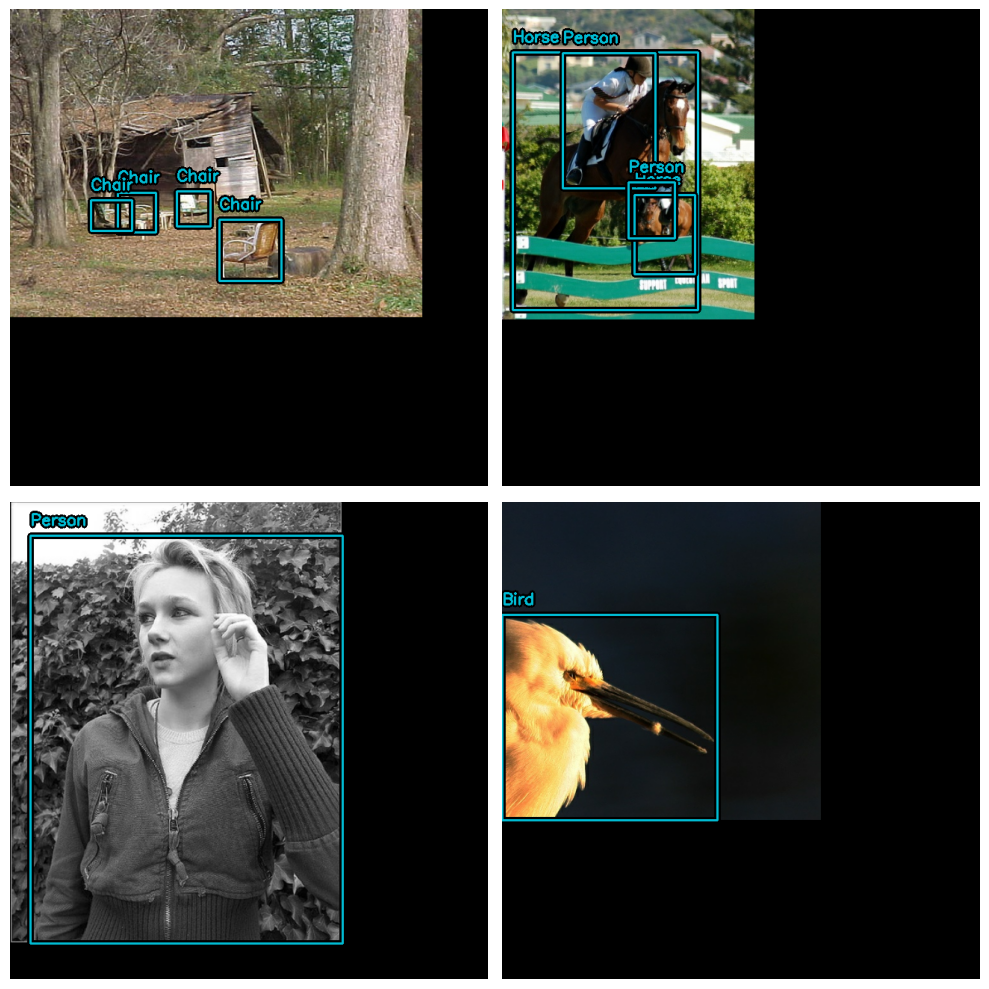

In [17]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

좋습니다! 이제 바운딩 박스 친화적인 데이터 보강 파이프라인이 있습니다.
평가 데이터 세트를 일치하도록 포맷해 보겠습니다.
`JitteredResize`를 사용하는 대신,
결정론적(deterministic) `keras_cv.layers.Resizing()` 레이어를 사용해 보겠습니다.

In [18]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

`JitteredResize()`를 사용하여 이미지 크기를 조정하는 트레이닝 데이터 세트와,
`layers.Resizing(pad_to_aspect_ratio=True)`를 사용하는 추론 데이터 세트 간의,
크기 조정 작업이 다르기 때문에 두 데이터 세트를 모두 시각화하는 것이 좋습니다.

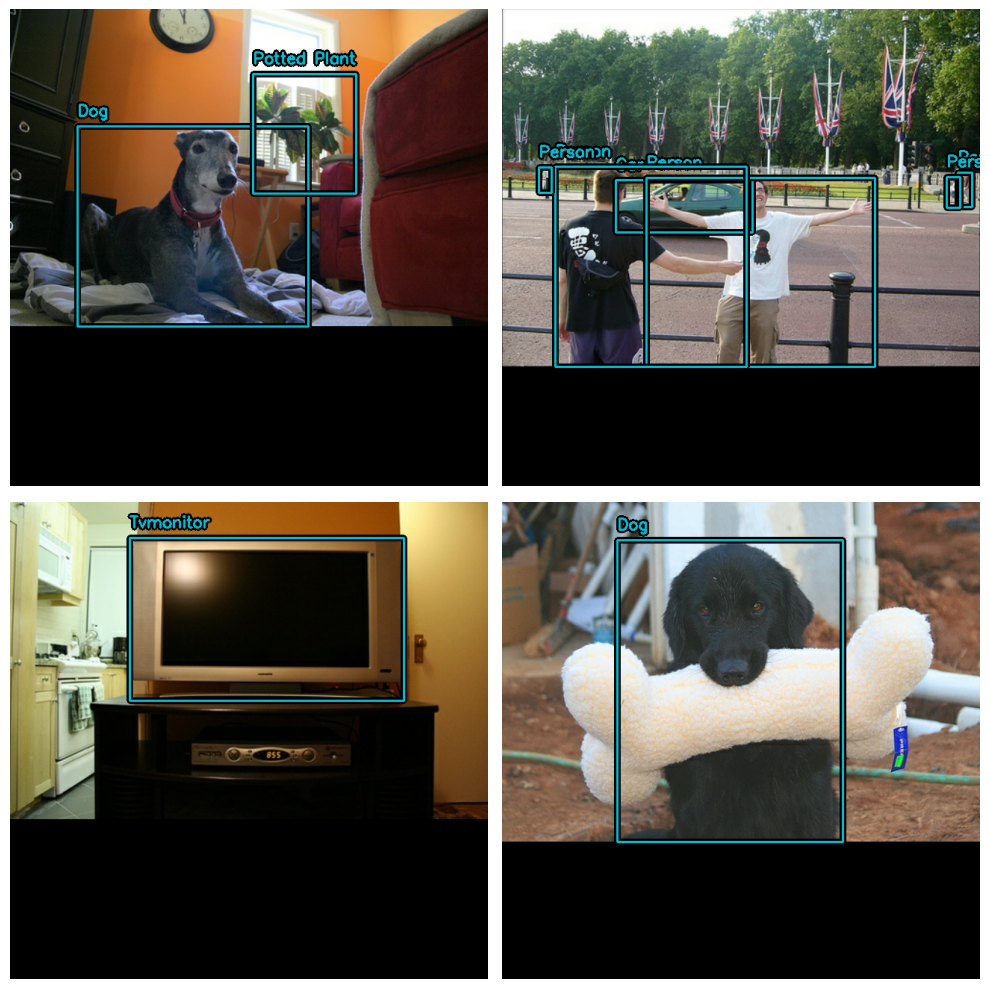

In [19]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

마지막으로, 사전 처리 딕셔너리에서 입력을 언패키징하고,
입력을 모델에 공급할 준비를 합시다.
TPU와 호환되기 위해, 바운딩 박스 텐서는 `Ragged` 대신 `Dense`여야 합니다.

In [20]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

### 옵티마이저

이 가이드에서는, 표준 SGD 옵티마이저를 사용하고,
[`keras.callbacks.ReduceLROnPlateau`](https://codecompose7.github.io/keras-doc-kr.github.io/api/callbacks/reduce_lr_on_plateau/) 콜백을 사용하여 학습률을 줄입니다.

객체 감지 모델을 트레이닝할 때는 항상 `global_clipnorm`을 포함해야 합니다.
이는 객체 감지 모델을 트레이닝할 때 자주 발생하는 폭발하는 그래디언트 문제를 해결하기 위한 것입니다.

In [21]:
base_lr = 0.005
# global_clipnorm을 포함하는 것은 객체 감지 작업에서 매우 중요합니다.
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

데이터 세트에서 최상의 결과를 얻으려면,
`PiecewiseConstantDecay` 학습률 스케쥴을 직접 만들어야 할 것입니다.
`PiecewiseConstantDecay` 스케쥴은 더 나은 성능을 보이는 경향이 있지만, 문제 간에 변환되지 않습니다.

### 손실 함수

`"ciou"` 손실에 익숙하지 않을 수도 있습니다.
다른 모델에서는 흔하지 않지만, 이 손실은 때때로 객체 감지 세계에서 사용됩니다.

간단히 말해서, ["Complete IoU"](https://arxiv.org/abs/1911.08287)는,
Intersection over Union 손실의 한 종류이며, 수렴 속성 때문에 사용됩니다.

KerasCV에서, 이 손실은 `"ciou"` 문자열을 `compile()`에 전달하기만 하면 사용할 수 있습니다.
또한 클래스 헤드에 표준 이진 교차 엔트로피 손실을 사용합니다.

In [22]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

### 메트릭 평가

가장 인기 있는 객체 감지 메트릭은 MSCOCO 데이터 세트와 함께 게시된 COCO 메트릭입니다.
KerasCV는 `keras_cv.callbacks.PyCOCOCallback` 심볼 아래에 사용하기 쉬운 COCO 메트릭 모음을 제공합니다.
COCO 메트릭을 계산하기 위해 Keras 메트릭 대신 Keras 콜백을 사용한다는 점에 유의하세요.
COCO 메트릭을 계산하려면,
전체 평가 데이터 세트에 대한 모델의 모든 예측을 한 번에 메모리에 저장해야 하기 때문이며,
이는 트레이닝 시간 동안에는 실행하기 어렵습니다.

In [23]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

이제 데이터 파이프라인이 완료되었습니다!
이제 모델 생성 및 트레이닝으로 넘어갈 수 있습니다.

## 모델 생성

다음으로, KerasCV API를 사용하여 트레이닝되지 않은 YOLOV8Detector 모델을 구성해 보겠습니다.
이 튜토리얼에서는 imagenet 데이터세트에서 사전 트레이닝된 ResNet50 백본을 사용합니다.

KerasCV를 사용하면 모든 KerasCV 백본으로 `YOLOV8Detector`를 쉽게 구성할 수 있습니다.
원하는 아키텍처에 대한 사전 설정 중 하나를 사용하기만 하면 됩니다!

예를 들어:

In [24]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # 지원되는 바운딩 박스 형식에 대한 자세한 내용은 다음을 방문하세요.
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)

100%|██████████| 777/777 [00:00<00:00, 955kB/s]
100%|██████████| 90.3M/90.3M [00:06<00:00, 15.0MB/s]


이것이 KerasCV YOLOv8을 구성하는 데 필요한 전부입니다.
YOLOv8은 `fit()` 및 `train_on_batch()`에 대한 dense 이미지 텐서와 바운딩 박스 사전의 튜플을 허용합니다.

이것은 위의 입력 파이프라인에서 구성한 것과 일치합니다.

## 모델 트레이닝

남은 일은 모델을 트레이닝하는 것입니다.
KerasCV 객체 감지 모델은 표준 Keras 워크플로를 따르며, `compile()` 및 `fit()`를 활용합니다.

모델을 컴파일해 보겠습니다.


In [25]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

모델을 완전히 트레이닝시키려면,
모든 데이터 세트 참조(아래 및 메트릭 콜백 초기화 부분)에서 `.take(20)`을 제거하세요.

In [26]:
model.fit(
    train_ds.take(20),
    # 좋은 점수를 얻으려면 10-35~ 에포크를 실행하세요.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 |

## 추론 및 결과 플로팅

KerasCV는 객체 감지 추론을 간단하게 만듭니다.
`model.predict(images)`는 경계 상자의 텐서를 반환합니다.
기본적으로, `YOLOV8Detector.predict()`는 non max 억제 연산을 수행합니다.

이 섹션에서는, `keras_cv`에서 제공하는 사전 설정을 사용합니다.

In [27]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

다음으로, 편의상 더 큰 배치를 포함하는 데이터 세트를 구성합니다.

In [28]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

추론 결과를 그래프로 표시하는 간단한 함수를 만들어 보겠습니다.

In [29]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


시각적으로 매력적인 결과를 얻으려면, NonMaxSuppression 연산을 구성해야 할 수도 있습니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


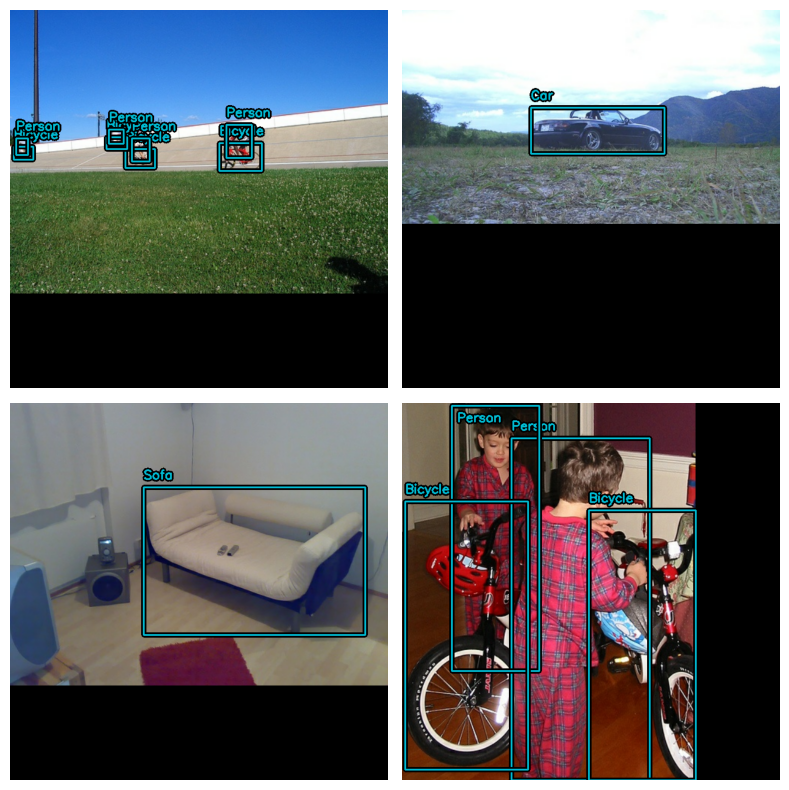

In [30]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

대단합니다!
마지막으로 알아두어야 할 유용한 패턴은 [`keras.callbacks.Callback`](https://codecompose7.github.io/keras-doc-kr.github.io/api/callbacks/base_callback#callback-class)에서 감지를 시각화하여 트레이닝을 모니터링하는 것입니다.

In [31]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_ds
        )

## 주요 내용 및 다음 단계

KerasCV를 사용하면 최첨단 객체 감지 파이프라인을 쉽게 구축할 수 있습니다.
이 가이드에서는, KerasCV 바운딩 박스 사양을 사용하여, 데이터 로더를 작성하는 것으로 시작했습니다.
이어서 50줄 미만의 코드로 KerasCV 전처리 레이어를 사용하여, 프로덕션 등급 데이터 보강 파이프라인을 조립했습니다.

KerasCV 객체 감지 구성 요소는 독립적으로 사용할 수 있지만, 서로 긴밀하게 통합되어 있습니다.
KerasCV를 사용하면 프로덕션 등급 바운딩 박스 보강, 모델 트레이닝, 시각화 및 메트릭 평가를 쉽게 작성할 수 있습니다.

독자를 위한 몇 가지 후속 연습:

* 모델 성능을 개선하기 위한 추가 보강 기술 추가
* 고품질 결과를 생성하는 데 사용되는 하이퍼파라미터 및 데이터 보강 조정
* 자체 데이터 세트에서 객체 감지 모델 트레이닝

KerasCV API의 힘을 보여주는 마지막 재미있는 코드 조각!

In [32]:
stable_diffusion = keras_cv.models.StableDiffusionV2(512, 512)
images = stable_diffusion.text_to_image(
    prompt="A zoomed out photograph of a cool looking cat.  The cat stands in a beautiful forest",
    negative_prompt="unrealistic, bad looking, malformed",
    batch_size=4,
    seed=1231,
)
encoded_predictions = model(images)
y_pred = model.decode_predictions(encoded_predictions, images)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    y_pred=y_pred,
    rows=2,
    cols=2,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL
1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1361968152/1361968152 ━━━━━━━━━━━━━━━━━━━━ 81s 0us/step
3464605600/3464605600 ━━━━━━━━━━━━━━━━━━━━ 359s 0us/step


ValueError: Invalid input shape for input Traced<ShapedArray(float32[4,77,1024])>with<DynamicJaxprTrace(level=1/0)>. Expected shape (None, 64, 64, 4), but input has incompatible shape (4, 77, 1024)